# Word2Vec: an introduction

Following: http://www.folgertkarsdorp.nl/word2vec-an-introduction/

Word2Vec (Mikolov et al, 2013) is a tool for learning continuous word embeddings from raw text. It associates words with points in space, and the spatial distance between words describes the similarity between them. Words are represented by continuous vectors over `x` dimensions.

In [1]:
import seaborn as sb
import numpy as np

/Users/perdue/anaconda/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


In [2]:
%matplotlib inline

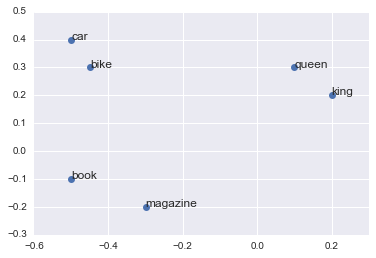

In [3]:
words = ['queen', 'book', 'king', 'magazine', 'car', 'bike']
vectors = np.array([[0.1, 0.3],
                   [-0.5, -0.1],
                   [0.2, 0.2],
                   [-0.3, -0.2],
                   [-0.5, 0.4],
                   [-0.45, 0.3]])
sb.plt.plot(vectors[:,0], vectors[:,1], 'o')
sb.plt.xlim(-0.6, 0.3)
sb.plt.ylim(-0.3, 0.5)
for word, x, y in zip(words, vectors[:,0], vectors[:,1]):
    sb.plt.annotate(word, (x, y), size=12)

The displacement vector describes the relationship between two words and we can often find analogies by looking for pairs of words with similar displacement vectors, e.g. `v[queen] - v[king] ~ v[woman] - v[man]`.

Word2vec learns continuous word embeddings by assuming the "distributional hypothesis". The means words may be characterized by words they are close to.

In [4]:
import pandas as pd

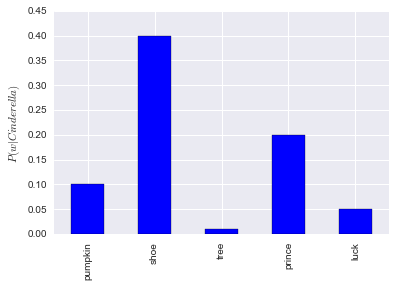

In [5]:
s = pd.Series([0.1, 0.4, 0.01, 0.2, 0.05],
             index=["pumpkin", "shoe", "tree", "prince", "luck"])
s.plot(kind='bar')
sb.plt.ylabel("$P(w|Cinderella)$")

## Softmax Regression

Word2Vec uses a neural network with one hidden layer.

<img src="http://www.folgertkarsdorp.nl/content/images/2015/01/neural-network.png">

The model considers each word along with a given context, e.g., $w_0$ = Cinderella, and $C$ = shoe. Given a context, can we predict $w_0$? This is mutlticlass classification with as many labels as our vocabulary size. We train by minimizing the cross entropy between the network output and the target distribution (as a one-hot vector) via stochastic gradient descent.

We have two weights matrices $W$ and $W'$ with dimensions $V \times N$ and $N \times V$ where $V$ is our vocabulary size and $N$ is the number of neurons in the hidden layer.

In [6]:
sentences = [
    'the king loves the queen',
    'the queen loves the king',
    'the dwarf hates the king',
    'the queen hates the dwarf',
    'the dwarf poisons the king',
    'the dwarf poisons the queen'
]

In [7]:
from collections import defaultdict

In [8]:
def Vocabulary():
    dictionary = defaultdict()
    dictionary.default_factory = lambda: len(dictionary)
    return dictionary

def docs2bow(docs, dictionary):
    """
    transform a list of strings into a list of lists with each unique item converted
    into a unique integer (equal to the order of first appearance for a word in the corpus)
    """
    # what is below is slicker way of doing this thing:
    # retd = []
    # for doc in docs:
    #     retd.append([dictionary[word] for word in doc.split()])
    # return retd
    # ok, but this is cooler:
    for doc in docs:
        yield [dictionary[word] for word in doc.split()]

In [9]:
vocabulary = Vocabulary()
sentences_bow = list(docs2bow(sentences, vocabulary))

In [10]:
sentences_bow

[[0, 1, 2, 0, 3],
 [0, 3, 2, 0, 1],
 [0, 4, 5, 0, 1],
 [0, 3, 5, 0, 4],
 [0, 4, 6, 0, 1],
 [0, 4, 6, 0, 3]]

In [11]:
vocabulary

defaultdict(<function __main__.<lambda>>,
            {'dwarf': 4,
             'hates': 5,
             'king': 1,
             'loves': 2,
             'poisons': 6,
             'queen': 3,
             'the': 0})

We may now construct $W$ and $W'$:

In [12]:
V, N = len(vocabulary), 3
WI = (np.random.random((V, N)) - 0.5) / N
WO = (np.random.random((N, V)) - 0.5) / N

In [13]:
print np.shape(WI)
print np.shape(WO)

(7, 3)
(3, 7)


In [14]:
WI

array([[ 0.14256685,  0.07760353, -0.08811524],
       [ 0.02855081,  0.10705906,  0.12814954],
       [ 0.01072809,  0.03650268,  0.08153707],
       [-0.14193338, -0.02325736, -0.13493665],
       [-0.11538327, -0.09355099, -0.09103295],
       [-0.11477681, -0.03040523, -0.07367318],
       [ 0.09000847, -0.0269599 , -0.15371617]])

In [15]:
WO

array([[-0.11035288, -0.09358348, -0.11186635, -0.01527572, -0.14394198,
         0.06560251,  0.00589856],
       [ 0.05008315, -0.07036849,  0.07293546, -0.09941825, -0.10766639,
         0.10530506,  0.04712601],
       [ 0.10166214, -0.14258583,  0.05384612, -0.10994551, -0.01022062,
         0.03903154, -0.056038  ]])

Each row $i$ in $W$ corresponds to a word $i$ and each column $j$ corresponds to the $j$th dimension ($j$th hidden neuron).

With these matrices we can compute the distance between an input word and the probability an output is a given value. For example, if the input is 'dwarf', what is the probability the output is 'hates'? The dot of the matrices gives us a "distance":

In [16]:
vocabulary['dwarf']

4

In [17]:
WI[vocabulary['dwarf']]

array([-0.11538327, -0.09355099, -0.09103295])

In [18]:
WO.T[vocabulary['hates']]

array([ 0.06560251,  0.10530506,  0.03903154])

In [19]:
print np.dot(WI[vocabulary['dwarf']], WO.T[vocabulary['hates']])

-0.0209739800237


In [20]:
for word in vocabulary.keys():
    print word, np.dot(WI[vocabulary['dwarf']], WO.T[vocabulary[word]])

king 0.0303610182723
dwarf 0.0276112058126
queen 0.0210719019858
poisons 1.20245642558e-05
loves 0.00118255058962
the -0.00120705654063
hates -0.0209739800237


Using a softmax function, we can trasnform these outputs into probabilities across our whole vocabulary:

\begin{equation}
P(w_O|w_I) = y_i = \frac{exp(W_I \cdot W_{O}^{'T})}{\sum_{j=1}^{V} exp(W_I \cdot W_{j}^{'T})}
\end{equation}

In [21]:
p = np.exp(-np.dot(WI[vocabulary['dwarf']], WO.T[vocabulary['hates']])) / \
    sum(np.exp(-np.dot(WI[vocabulary['dwarf']], WO.T[vocabulary[w]])) for w in vocabulary)

In [22]:
print p

0.147078088345


In [23]:
1/7.

0.14285714285714285

## Updating the hidden-to-output layer weights

Word2Vec initially embeds words randomly, so we must learn better positions. We train by minimizing a loss function, $E = - \log P(w_O | w_I)$. Given the one-hot target distribution, $t$, the error may be computed as $t_j - y_j = e_j$, where $t_j$ is 1 iff $w_j$ is the actual output word.

To obtain the gradient on the hidden-to-output weights, we compute $e_j \cdot h_i$, where $h_i$ is a copy of the vector for the input word (this is true only with the context of a single word). Then we may use stochastic gradient descent with learning rate $\nu$ to obtain an update equation for the hidden-to-output weights:

\begin{equation}
W_{j}^{'T(t)} = W_{j}^{'T(t-1)} - \nu \cdot e_j \cdot h_j 
\end{equation}

In [24]:
target_word = 'king'
input_word = 'queen'
learning_rate = 1.0

for word in vocabulary:
    p_word_queen = (
        np.exp(-np.dot(WO.T[vocabulary[word]], WI[vocabulary[input_word]])) / 
            sum(np.exp(-np.dot(WO.T[vocabulary[w]], WI[vocabulary[input_word]])) for w in vocabulary)
    )
    t = 1 if word == target_word else 0
    error = t - p_word_queen
    print p_word_queen, word, t, error

0.139511454877 king 1 0.860488545123
0.140891857345 dwarf 0 -0.140891857345
0.14159770185 queen 0 -0.14159770185
0.143549169417 poisons 0 -0.143549169417
0.143364523437 loves 0 -0.143364523437
0.14424683487 the 0 -0.14424683487
0.146838458205 hates 0 -0.146838458205


In [25]:
target_word = 'king'
input_word = 'queen'
learning_rate = 1.0

for word in vocabulary:
    p_word_queen = (
        np.exp(-np.dot(WO.T[vocabulary[word]], WI[vocabulary[input_word]])) / 
            sum(np.exp(-np.dot(WO.T[vocabulary[w]], WI[vocabulary[input_word]])) for w in vocabulary)
    )
    t = 1 if word == target_word else 0
    error = t - p_word_queen
    print p_word_queen, word, t, error, WO.T[vocabulary[word]]
    WO.T[vocabulary[word]] = (
        WO.T[vocabulary[word]] - learning_rate * error * WI[vocabulary[input_word]]
    )
    print "new = ", WO.T[vocabulary[word]]
    
print WO.T

0.139511454877 king 1 0.860488545123 [-0.09358348 -0.07036849 -0.14258583]
new =  [ 0.02854857 -0.0503558  -0.02647439]
0.140226043676 dwarf 0 -0.140226043676 [-0.14394198 -0.10766639 -0.01022062]
new =  [-0.16384473 -0.11092768 -0.02914225]
0.141036121117 queen 0 -0.141036121117 [-0.01527572 -0.09941825 -0.10994551]
new =  [-0.03529345 -0.10269837 -0.12897645]
0.143090247182 poisons 0 -0.143090247182 [ 0.00589856  0.04712601 -0.056038  ]
new =  [-0.01441072  0.0437981  -0.07534612]
0.143019768293 loves 0 -0.143019768293 [-0.11186635  0.07293546  0.05384612]
new =  [-0.13216563  0.06960919  0.03454751]
0.14401421202 the 0 -0.14401421202 [-0.11035288  0.05008315  0.10166214]
new =  [-0.1307933   0.04673376  0.08222934]
0.146719678387 hates 0 -0.146719678387 [ 0.06560251  0.10530506  0.03903154]
new =  [ 0.04477809  0.10189275  0.01923368]
[[-0.1307933   0.04673376  0.08222934]
 [ 0.02854857 -0.0503558  -0.02647439]
 [-0.13216563  0.06960919  0.03454751]
 [-0.03529345 -0.10269837 -0.1289

## Updating the input-to-hidden layer weights

Next we must backpropagate the prediction errors to the input-to-hidden weights. We first compute $EH$, which is an $N$-dimensional vector representing the sum of the hidden-to-ouput vectors for each word in the vocabulary weighted by their prediction error:

\begin{equation}
\sum_{j=1}^V e_j \cdot W_{i,j}^{'} = EH_i
\end{equation}

Using the learning rate $\nu$ we update the weights with:

\begin{equation}
W_{w_I}^{(t)} = W_{w_I}^{(t-1)} - \nu \cdot EH 
\end{equation}

In [26]:
WI[vocabulary[input_word]] = WI[vocabulary[input_word]] - learning_rate * WO.sum(1)

Now we see the probability of 'king' given 'queen' has gone up:

In [27]:
for word in vocabulary:
    p = (np.exp(-np.dot(WO.T[vocabulary[word]],
                       WI[vocabulary[input_word]])) /
        sum(np.exp(-np.dot(WO.T[vocabulary[w]], 
                          WI[vocabulary[input_word]]))
           for w in vocabulary))
    print word, p

king 0.139486600404
dwarf 0.146483201397
queen 0.141514672801
poisons 0.14126816146
loves 0.145938145581
the 0.145891292642
hates 0.139417925715


## Multi-word context

The model described above is the CBOW architecture of Word2Vec. But, we assumed the context $C$ was only a single input word. This allowed us to simply copy the input vector to the hidden layer. But, if $C$ is multiple words, we take the mean of their input vectors as the hidden layer:

\begin{equation}
h = \frac{1}{C} (W_1 + W_2 + \cdots + W_C)
\end{equation}

The update function remains the same, when we update the input vectors, we need to apply the update to each word in the context:

\begin{equation}
W_{W_I}^{(t)} = W_{W_I}^{(t-1)} - \frac{1}{C} \cdot \nu \cdot EH 
\end{equation}

In [28]:
target_word = 'king'
context = ['queen', 'loves']

h = (WI[vocabulary['queen']] + WI[vocabulary['loves']]) / 2

In [29]:
h

array([ 0.13598794,  0.00759668,  0.03526455])

In [30]:
for word in vocabulary:
    p = (np.exp(-np.dot(WO.T[vocabulary[word]], h)) / 
        sum(np.exp(-np.dot(WO.T[vocabulary[w]], h))
           for w in vocabulary))
    t = 1 if word == target_word else 0
    error = t - p
    WO.T[vocabulary[word]] = (WO.T[vocabulary[word]] - learning_rate * error * h)
    
print WO

[[-0.11126467 -0.08822655 -0.11261188 -0.01587416 -0.14415935  0.06388817
   0.00490321]
 [ 0.04782468 -0.05687919  0.07070152 -0.10161356 -0.10982799  0.10296029
   0.04487704]
 [ 0.08729353 -0.05675665  0.03961821 -0.12394062 -0.02403741  0.02418933
  -0.07033761]]


In [31]:
for word in context:
    WI[vocabulary[word]] = (WI[vocabulary[word]] - (1. / len(context)) * learning_rate * WO.sum(1))

In [32]:
for word in vocabulary:
    p = (np.exp(-np.dot(WO.T[vocabulary[word]],
                       WI[vocabulary[input_word]])) /
        sum(np.exp(-np.dot(WO.T[vocabulary[w]], 
                          WI[vocabulary[input_word]]))
           for w in vocabulary))
    print word, p

king 0.144947901187
dwarf 0.148342289977
queen 0.140526540949
poisons 0.139215599995
loves 0.146253831606
the 0.1457400502
hates 0.134973786086
